# Credit card fraud detection

In this lab we'll use a credit card fraud dataset to predict fraudulent transactions.  This dataset The contains transactions made by credit cards in September 2013 by European cardholders.  This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions (Highly Imbalanced!)

In this example we will use the built in XGBoost Classification algorithm.

Let's get started by downloading the dataset to our notebook instance for inspection

In [1]:
!pip install -U imbalanced-learn

     |████████████████████████████████| 206 kB 24.2 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import boto3
import os
import sagemaker
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.model_selection import train_test_split
from sagemaker.predictor import csv_serializer 
from sagemaker.debugger import Rule, rule_configs
from imblearn.over_sampling import SMOTE, ADASYN

In [2]:
# sagemaker session
session = sagemaker.Session()
sagemaker_iam_role = sagemaker.get_execution_role()

# data location
bucket = session.default_bucket()
prefix = 'DEMO-xgboost-fraud'

## Investigate and process the data

Let's start by downloading and reading in the credit card fraud data set.

In [3]:
# creating directory structure
!mkdir -p ./data

In [4]:
# download from s3 to the ./data/ folder
!curl https://s3-us-west-2.amazonaws.com/sagemaker-e2e-solutions/fraud-detection/creditcardfraud.zip -o ./data/creditcardfraud.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 65.9M  100 65.9M    0     0  25.7M      0  0:00:02  0:00:02 --:--:-- 25.7M


In [5]:
# uncompress the dataset
!unzip -o ./data/creditcardfraud.zip -d ./data/

Archive:  ./data/creditcardfraud.zip
  inflating: ./data/creditcard.csv   


In [6]:
# read in data with pandas
data = pd.read_csv('./data/creditcard.csv', delimiter=',')

Let's take a peek at our data (we only show a subset of the columns in the table):

In [7]:
print(data.columns)
data.head(10)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


This dataset has 28 columns, $V_i$ for $i=1..28$ of anonymized features along with columns for time, amount, and class. We already know that the columns $V_i$ have been normalized to have $0$ mean and unit standard deviation as the result of a PCA. You can read more about PCA here - https://en.wikipedia.org/wiki/Principal_component_analysis 

In [8]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [9]:
nonfrauds, frauds = data.groupby('Class').size()
print('Number of frauds: ', frauds)
print('Number of non-frauds: ', nonfrauds)
print('Percentage of fradulent data: {:.3%}'.format(frauds/(frauds + nonfrauds)))

Number of frauds:  492
Number of non-frauds:  284315
Percentage of fradulent data: 0.173%


The class column corresponds to whether or not a transaction is fradulent. We see that the majority of data is non-fraudulant with only $492$ ($.173\%$) of the data corresponding to fraudulant examples.

In [10]:
feature_columns = data.columns[:-1]
label_column = data.columns[-1]

features = data[feature_columns].values.astype('float32')
labels = (data[label_column].values).astype('float32')

For this example we are going to train an XGBoost Classification algorithm without addressing the class imbalance

## SageMaker XGBoost

### Prepare Data and Upload to S3

In [11]:
# move class to the first column
model_data = data
model_data = pd.concat([model_data['Class'], model_data.drop(['Class'], axis=1)], axis=1)
model_data.head()

,Class,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,0,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,0,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,0,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


### Split the data into train | validation | test datasets

In [12]:
# data split and save as CSV - 70/20/10
train_df, temp_df = train_test_split(model_data, test_size=0.3, random_state=4321, shuffle=True, stratify=model_data['Class'])
val_df, test_df = train_test_split(temp_df, test_size=0.33333, random_state=4321, shuffle=True, stratify=temp_df['Class'])

train_df.to_csv('./data/train.csv', header=False, index=False)
val_df.to_csv('./data/validation.csv', header=False, index=False)
test_df.to_csv('./data/test.csv', header=False, index=False)

In [13]:
train_df.iloc[:,1::]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
6032,6796.0,-0.302864,-2.550406,1.546981,2.810913,-1.744703,2.334523,-0.850368,0.628317,2.314988,...,1.067747,0.372560,0.316427,-0.580631,-0.209118,-0.189550,1.117333,-0.101294,0.114515,657.22
236531,148848.0,-0.364365,0.954357,-1.979413,-1.498087,2.747691,3.222585,0.045242,1.208898,-0.257880,...,-0.078776,0.424978,1.198101,-0.019480,0.737109,-0.740880,-0.208901,0.268847,0.249455,1.29
59039,48664.0,-0.368585,1.125132,1.304311,0.068310,0.101569,-0.994461,0.724027,-0.098055,-0.465908,...,0.157145,-0.254401,-0.651778,-0.010525,0.347213,-0.142180,0.070202,0.247047,0.100165,4.49
180693,124659.0,2.066051,0.036608,-1.964909,0.150379,0.763664,-0.118960,0.016042,0.010232,0.364742,...,-0.165875,-0.355226,-0.974553,0.261211,-0.224832,-0.237995,0.200831,-0.068165,-0.048765,2.69
61926,50050.0,1.108032,-0.098991,0.986011,1.374827,-0.864433,-0.297631,-0.368379,0.017477,0.791485,...,-0.077765,0.108374,0.474877,-0.168221,0.422549,0.637948,-0.218857,0.053415,0.035579,41.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10608,17741.0,-1.050505,1.180388,2.015312,2.300229,0.831815,1.683762,0.667792,0.366853,-0.293545,...,-0.198628,0.058168,0.500763,0.016286,-0.694642,0.032653,0.233568,-0.007830,0.025315,68.34
62066,50108.0,1.159811,-0.116225,0.815330,1.104101,-0.652255,0.025108,-0.558789,0.140083,0.696400,...,-0.084404,0.058761,0.069790,-0.130330,-0.497074,0.398471,-0.309213,0.046506,0.036345,45.00
168522,119266.0,2.068354,-1.171112,-0.641570,-0.932404,-0.999704,-0.189217,-1.087789,0.013847,-0.089462,...,0.075754,0.576517,1.691519,-0.082786,-0.386311,0.020380,0.124942,0.004587,-0.059042,50.00
68952,53203.0,0.819379,-1.124913,0.515025,0.513945,-1.009048,0.488484,-0.580672,0.187686,-0.999142,...,-0.110144,-0.057205,-0.168061,-0.198732,-0.337408,0.238538,-0.289454,0.038214,0.058407,228.00


### Oversample with SMOTE

In [14]:
X_resampled, y_resampled = SMOTE().fit_resample(train_df.iloc[:,1::],train_df.iloc[:,0])

In [21]:
y_resampled = y_resampled.values.reshape((y_resampled.shape[0],1))

X = X_resampled
y = y_resampled

print(X.shape)
print(y.shape)
train_data = np.concatenate((y, X),axis=1)
train_data = pd.DataFrame(train_data)
train_data.shape

(398040, 30)
(398040, 1)


(398040, 31)

In [23]:
train_data.to_csv('./data/train_resampled.csv', header=False, index=False)

### Now we upload the data to S3 using boto3

In [25]:
output_location = f's3://{bucket}/{prefix}/output'
s3_train_data = f's3://{bucket}/{prefix}/train/train_resampled.csv'
s3_validation_data = f's3://{bucket}/{prefix}/validation/validation.csv'

# upload to s3 bucket defined above
session.upload_data('./data/train_resampled.csv',bucket,f'{prefix}/train')
session.upload_data('./data/validation.csv',bucket,f'{prefix}/validation')

print('Uploaded training data location: {}'.format(s3_train_data))
print('Uploaded training data location: {}'.format(s3_validation_data))
print('Training artifacts will be uploaded to: {}'.format(output_location))

Uploaded training data location: s3://sagemaker-us-east-1-431615879134/DEMO-xgboost-fraud/train/train_resampled.csv
Uploaded training data location: s3://sagemaker-us-east-1-431615879134/DEMO-xgboost-fraud/validation/validation.csv
Training artifacts will be uploaded to: s3://sagemaker-us-east-1-431615879134/DEMO-xgboost-fraud/output


In [26]:
# check shapes
print('Training Data Shape: ',train_data.shape)
print('Validation Data Shape: ',val_df.shape)
print('Testing Data Shape: ',test_df.shape)

Training Data Shape:  (398040, 31)
Validation Data Shape:  (56962, 31)
Testing Data Shape:  (28481, 31)


---
## Train

Moving onto training, first we'll need to specify the locations of the XGBoost algorithm containers.  A complete list of build-in algorithms is found here: https://docs.aws.amazon.com/sagemaker/latest/dg/algos.html

In [27]:
container = sagemaker.image_uris.retrieve('xgboost',boto3.Session().region_name,version='1.3-1')
print(container)

683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.3-1


In [28]:
# configure Xgboost Report
rules=[Rule.sagemaker(rule_configs.create_xgboost_report())]

Then, because we're training with the CSV file format, we'll create TrainingInput that our training function can use as a pointer to the files in S3.

In [29]:
s3_input_train = sagemaker.TrainingInput(s3_data=f's3://{bucket}/{prefix}/train', content_type='csv')
s3_input_validation = sagemaker.TrainingInput(s3_data=f's3://{bucket}/{prefix}/validation/', content_type='csv')

Now, we can specify a few parameters like what type of training instances we'd like to use and how many, as well as our XGBoost hyperparameters.  A few key hyperparameters are:
- `max_depth` controls how deep each tree within the algorithm can be built.  Deeper trees can lead to better fit, but are more computationally expensive and can lead to overfitting.  There is typically some trade-off in model performance that needs to be explored between a large number of shallow trees and a smaller number of deeper trees.
- `subsample` controls sampling of the training data.  This technique can help reduce overfitting, but setting it too low can also starve the model of data.
- `num_round` controls the number of boosting rounds.  This is essentially the subsequent models that are trained using the residuals of previous iterations.  Again, more rounds should produce a better fit on the training data, but can be computationally expensive or lead to overfitting.
- `eta` controls how aggressive each round of boosting is.  Larger values lead to more conservative boosting.
- `gamma` controls how aggressively trees are grown.  Larger values lead to more conservative models.

More detail on XGBoost's hyperparmeters can be found on their GitHub [page](https://github.com/dmlc/xgboost/blob/master/doc/parameter.md).

SageMaker abstracts training with Estimators. We can pass container, and all parameters to the estimator, as well as the hyperparameters and fit the estimator to the data in S3.

In [30]:
xgb = sagemaker.estimator.Estimator(container,
                                    role=sagemaker_iam_role, 
                                    instance_count=1, 
                                    instance_type='ml.m4.xlarge',
                                    output_path=output_location,
                                    sagemaker_session=session,
                                    rules=rules)

xgb.set_hyperparameters(eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        objective='binary:logistic',
                        num_round=50)

In [31]:
%%time
xgb.fit({'train': s3_input_train, 'validation': s3_input_validation}) 

2021-09-17 21:27:28 Starting - Starting the training job...
2021-09-17 21:27:51 Starting - Launching requested ML instancesCreateXgboostReport: InProgress
ProfilerReport-1631914048: InProgress
.........
2021-09-17 21:29:27 Starting - Preparing the instances for training.........
2021-09-17 21:30:54 Downloading - Downloading input data...
2021-09-17 21:31:27 Training - Downloading the training image..[2021-09-17 21:31:36.300 ip-10-2-179-131.ec2.internal:1 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-09-17:21:31:36:INFO] Imported framework sagemaker_xgboost_container.training
[2021-09-17:21:31:36:INFO] Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
[2021-09-17:21:31:36:INFO] No GPUs detected (normal if no gpus installed)
[2021-09-17:21:31:36:INFO] Running XGBoost Sagemaker in algorithm mode
[2021-09-17:21:31:36:INFO] Determined delimiter of CSV input is ','
[2021-09-17:21:31:36:INFO] Determined delimiter of CSV input is '

### Host XGBoost Model

Now we deploy the estimator to a realtime  endpoint.

In [33]:
%%time

xgb_predictor = xgb.deploy(initial_instance_count = 1, instance_type = 'ml.m4.xlarge',endpoint_name='deployed-xgboost-fraud-prediction-os',serializer=sagemaker.serializers.CSVSerializer())

-----------------!CPU times: user 227 ms, sys: 18.2 ms, total: 245 ms
Wall time: 8min 33s


In [34]:
# single row of data
print(test_df.iloc[2,0])
xgb_predictor.predict(test_df.iloc[2,1:])

0


b'0.00033815926872193813'

In [35]:
# single batch of data
print(test_df.iloc[3:10,0])
xgb_predictor.predict(test_df.iloc[3:10,1:].values)

151549    0
180991    0
40297     0
163717    0
171576    0
221936    0
46924     0
Name: Class, dtype: int64


b'0.0005599275464192033,0.00010742062295321375,0.00036857117083854973,0.0009987835073843598,0.0015809632604941726,4.27619852416683e-05,3.5875254980055615e-05'

### Evaluate

Now that we have a hosted endpoint running, we can make real-time predictions from our model simply by making an http POST request.  

Now, we'll use a simple function to:
1. Loop over our test dataset
1. Split it into mini-batches of rows 
1. Convert those mini-batchs to CSV string payloads
1. Retrieve mini-batch predictions by invoking the XGBoost endpoint
1. Collect predictions and convert from the CSV output our model provides into a NumPy array

In [36]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

In [37]:
predictions = predict(test_df.to_numpy()[:, 1:])

There are many ways to compare the performance of a machine learning model, but let's start by simply by comparing actual to predicted values. In this case, we're simply predicting fraud vs non-fraud, which produces a simple confusion matrix.

In [38]:
test_nonfrauds, test_frauds = test_df.groupby('Class').size()
print('Number of frauds: ', test_frauds)
print('Number of non-frauds: ', test_nonfrauds)
print('Percentage of fradulent data: {:.3%}'.format(test_frauds/(test_frauds + test_nonfrauds)))

Number of frauds:  49
Number of non-frauds:  28432
Percentage of fradulent data: 0.172%


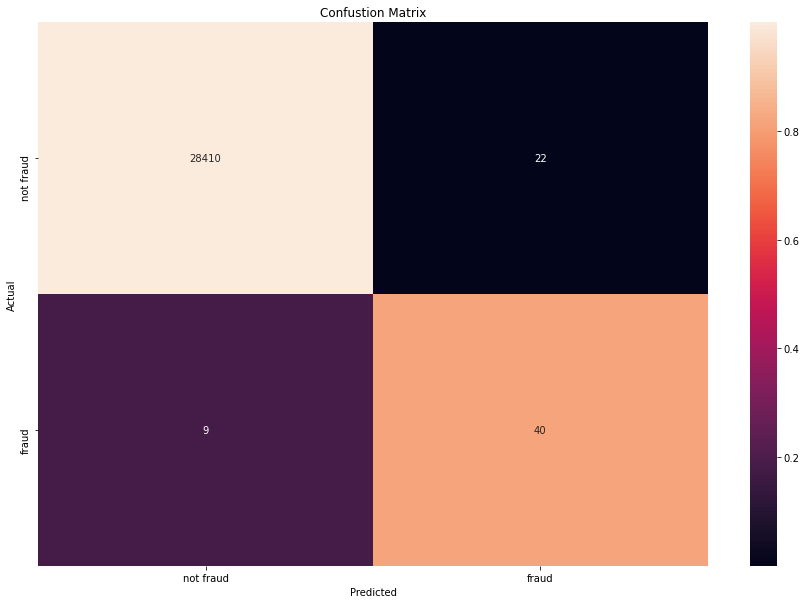

In [39]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
class_list = ['not fraud', 'fraud']
fig, ax = plt.subplots(figsize=(15,10))
cm = confusion_matrix(test_df.iloc[:, 0],np.round(predictions))
normalized_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, ax=ax, annot=cm, fmt='',xticklabels=class_list,yticklabels=class_list)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confustion Matrix')
plt.show()

In [40]:
#precision: tp / (tp + fp)
#recall: tp / (tp + fn)
from sklearn.metrics import precision_recall_fscore_support
results = precision_recall_fscore_support(test_df.iloc[:, 0],
                                         np.round(predictions))
print('precision: ', round(results[0][1], 2))
print('recall: ', round(results[1][1], 2))
print('F1: ', round(results[2][1], 2))

precision:  0.65
recall:  0.82
F1:  0.72


Note, due to randomized elements of the algorithm, your results may differ slightly.

Of the 49 fraudsters, we've correctly predicted 41 of them (true positives). And, we incorrectly predicted 3 case of fraud (false positive). There are also 8 cases of fraud that the model classified as benign transaction (false negatives) - which can get really expensive.

An important point here is that because of the np.round() function above we are using a simple threshold (or cutoff) of 0.5. Our predictions from xgboost come out as continuous values between 0 and 1 and we force them into the binary classes that we began with. So, we should consider adjusting this cutoff. That will almost certainly increase the number of false positives, but it can also be expected to increase the number of true positives and reduce the number of false negatives.

To get a rough intuition here, let's look at the continuous values of our predictions.

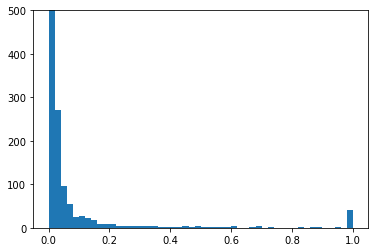

In [41]:
plt.hist(predictions,bins=50)
plt.ylim((0,500))
plt.show()

By varying the cutoff threshold, we can trade false positives for false negatives. 

In [50]:
thresh = 0.361

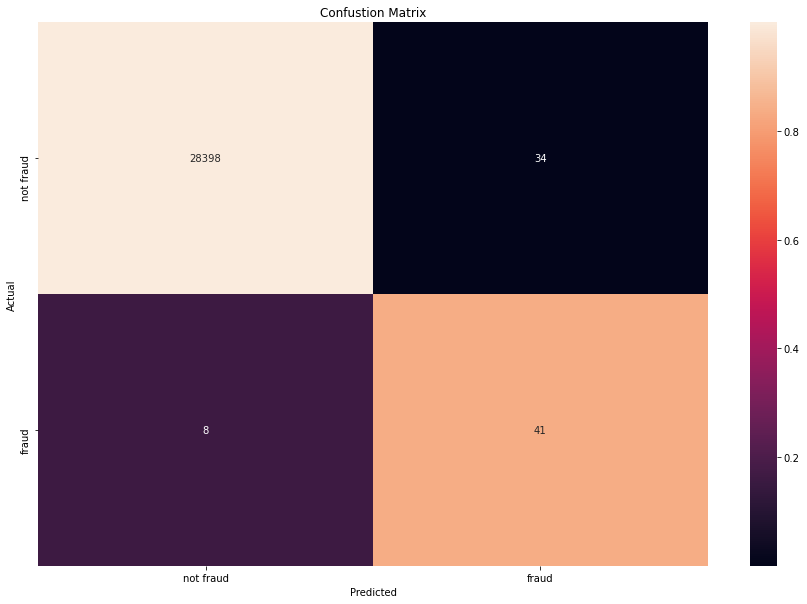

In [51]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
class_list = ['not fraud', 'fraud']
fig, ax = plt.subplots(figsize=(15,10))
cm = confusion_matrix(test_df.iloc[:, 0],np.where(predictions > thresh, 1, 0))
normalized_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, ax=ax, annot=cm, fmt='',xticklabels=class_list,yticklabels=class_list)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confustion Matrix')
plt.show()

This also changes the statistics on precision, recall, and the F1 score

In [47]:
results = precision_recall_fscore_support(test_df.iloc[:, 0],
                                         np.where(predictions > thresh, 1, 0))
print('precision: ', round(results[0][1], 2))
print('recall: ', round(results[1][1], 2))
print('F1: ', round(results[2][1], 2))

precision:  0.38
recall:  0.86
F1:  0.52


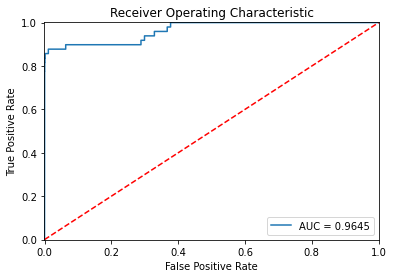

In [48]:
fpr, tpr, thresholds = roc_curve(test_df.iloc[:, 0], predictions)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-.001, 1.001])
plt.ylim([-.001, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

### Relative cost of errors

Any practical binary classification problem is likely to produce a similarly sensitive cutoff. 
If we put an ML model into production, there are costs associated with the model erroneously assigning false positives and false negatives. Because the choice of the cutoff affects all four of these statistics, we need to consider the relative costs to the business for each of these four outcomes for each prediction.

#### Assigning costs

What are the costs for our problem fraud detection? The costs, of course, depend on the specific actions that the business takes. Let's make some assumptions here.

First, assign the cost of \$0.00 to both the true negatives (correctly recognized benign transactions) and true positives (correctly recognized fraudulent transactions). Our model essentially correctly identified both situations. One can assign a benefit (i.e. negative cost) to correctly detected fraud, but we are not going to do this here.

False negatives are the most problematic, because they represent a fraudulent transactions that slipped through our model. Based on some Internet research (see sources below), we assign a cost of \$450.00 for each one. This is the cost of false negatives.

Finally, False positives are the genuine transactions that our model would block as fraud. This would result in an annoyed customer that might possibly close the credit card account and move to another bank. We assume that it costs a \$500.00 sign-on bonus to obtain a credit card customer and that 5 percent of annoyed customers would defect. 

Source:

* https://www.creditcards.com/credit-card-news/credit-card-security-id-theft-fraud-statistics-1276.php
* https://wallethub.com/edu/cc/credit-debit-card-fraud-statistics/25725/


#### Finding the optimal cutoff

It’s clear that false negatives are substantially more costly than false positives. We should be minimizing a cost function that looks like this:

```txt
$450 * FN(C) + $0 * TN(C) + 0.05*$500 * FP(C) + $0 * TP(C)
```

FN(C) means that the false negative percentage is a function of the cutoff, C, and similar for TN, FP, and TP.  We need to find the cutoff, C, where the result of the expression is smallest.

A straightforward, brute force, way to do this, is to simply run a simulation over a large number of possible cutoffs.  

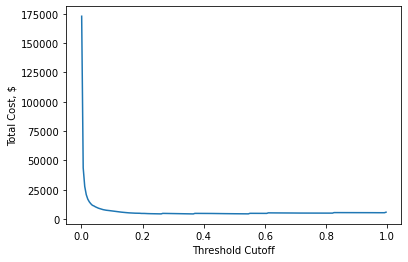

Cost is minimized near a cutoff of: 0.361


In [49]:
TN_cost = 0
TP_cost = 0
FP_cost = 0.05*500 #$cost of losing an annoyed customer (assuming 5% defection and $500 sign-on bonus)
FN_cost = 450 # $cost of of letting a fradulent transaction slip through

cutoffs = np.arange(0.001, 1, 0.005)
costs = []
for c in cutoffs:
    costs.append(np.sum(np.sum(np.array([[TN_cost, FP_cost], [FN_cost, TP_cost]]) * 
                               pd.crosstab(index=test_df.iloc[:, 0], 
                                           columns=np.where(predictions > c, 1, 0)))))

costs = np.array(costs)
plt.plot(cutoffs, costs)
plt.ylabel('Total Cost, $')
plt.xlabel('Threshold Cutoff')
plt.show()
print('Cost is minimized near a cutoff of:', cutoffs[np.argmin(costs)])

## Clean up

We will leave the prediction endpoint running at the end of this notebook so we can handle incoming event streams. However, don't forget to delete the prediction endpoint when you're done. You can do that at the Amazon SageMaker console in the Endpoints page. Or you can run `xgb_predictor.delete_endpoint()`

In [51]:
xgb_predictor.delete_endpoint()


## Data Acknowledgements

The dataset used to demonstrated the fraud detection solution has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the [DefeatFraud](https://mlg.ulb.ac.be/wordpress/portfolio_page/defeatfraud-assessment-and-validation-of-deep-feature-engineering-and-learning-solutions-for-fraud-detection/) project
We cite the following works:
* Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015
* Dal Pozzolo, Andrea; Caelen, Olivier; Le Borgne, Yann-Ael; Waterschoot, Serge; Bontempi, Gianluca. Learned lessons in credit card fraud detection from a practitioner perspective, Expert systems with applications,41,10,4915-4928,2014, Pergamon
* Dal Pozzolo, Andrea; Boracchi, Giacomo; Caelen, Olivier; Alippi, Cesare; Bontempi, Gianluca. Credit card fraud detection: a realistic modeling and a novel learning strategy, IEEE transactions on neural networks and learning systems,29,8,3784-3797,2018,IEEE
* Dal Pozzolo, Andrea Adaptive Machine learning for credit card fraud detection ULB MLG PhD thesis (supervised by G. Bontempi)
* Carcillo, Fabrizio; Dal Pozzolo, Andrea; Le Borgne, Yann-Aël; Caelen, Olivier; Mazzer, Yannis; Bontempi, Gianluca. Scarff: a scalable framework for streaming credit card fraud detection with Spark, Information fusion,41, 182-194,2018,Elsevier
* Carcillo, Fabrizio; Le Borgne, Yann-Aël; Caelen, Olivier; Bontempi, Gianluca. Streaming active learning strategies for real-life credit card fraud detection: assessment and visualization, International Journal of Data Science and Analytics, 5,4,285-300,2018,Springer International Publishing